
# Final Project for Data Mining Course, Data Science and Application 
## Metro College of Technology

### September, 2021

### Ana Clara Tupinambá Freitas, oriented by Professor Gitimoni Saikia

# COVID Cases

## Introduction

The past couple years have been disrupted by the COVID-19 pandemic. 
The predictors of this study are: 

    - Outbreak Associated  
    - Age Group   
    - Season   
    - Episode Month
    - Client Gender  
    - Count  

The **target** feature in this study will be: **Count of CONFIRMED cases**.

This study will try to answer some questions:

    - What factors may contribute to COVID positive numbers in Toronto? 
    - What groups should be the target of more attention? 
    - When should precaution be highlighted to persist? 

Data Source:https://open.toronto.ca/dataset/covid-19-cases-in-toronto/, downloaded at Sep 7th,2021

# Importing Packages

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import kstest
import researchpy as rp
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal

from sklearn.model_selection import train_test_split

# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm

import warnings

# User Defined Functions

## Univariate Categorical:

In [2]:
def uni_categorical(df,size):
    '''This function returns summarization and visual for univariate analysis of categorical features of a dataset'''
    print('############### Univariate analysis - Categorical ###############')
    df = df.select_dtypes(exclude=np.number) #extracting only non-numerical features
    for i in df.columns:
     #   if type(df.loc[0, i]) == str: #checking type of features
# Summarization
            d1 = df[i].value_counts()
            d2 = round(df[i].value_counts(normalize=True)*100, 2)
            d3 = pd.concat([d1, d2], axis=1)
            d3.columns = ['Count', 'Percentage']
            print('\nThis is univariate analysis for', "'", i, "'", '\n', d3)

 # Visualization
            d1 = pd.DataFrame(d1).T
            d1 = pd.melt(d1,var_name=str(i),value_vars=d1) 
            fig, ax = plt.subplots()
            if size == 'L':
                fig.set_size_inches(45, 10)
            else:
                fig.set_size_inches(12, 8)
            sns.set_context("paper", font_scale=1.5)
            plot1=sns.barplot(y=d1['value'],x=d1[i], data=d1)
            for p, label in zip(plot1.patches, d1['value']):
                ax.annotate(label, (p.get_x()+0.3, p.get_height()+2))
            plt.xticks(rotation=45, ha='right')
            ax.set_title('Univariate plot')
            plt.show()
    print('\n\n')

## Univariate Numerical:

In [3]:
def uni_numerical(df):
    '''This function returns summarization and visual for univariate analysis of numerical features of a dataset'''
    
# Summarization
    print('############### Univariate analysis - Numerical ###############')
    df.describe()

    Summary = dict(df.describe())
    for i in Summary:
        Summary[i]['count'] = df[i].count()
        Summary[i]['variance'] = df[i].var()
        Summary[i]['IQR'] = Summary[i]['75%'] - Summary[i]['25%']
        Summary[i]['range'] = Summary[i]['max'] - Summary[i]['min']
        Summary[i]['skewness'] = df[i].skew()
        Summary[i]['kurtosis'] = df[i].kurtosis()
        Summary[i]['mode'] = df[i].mode() #axis='columns'
#    print(Summary)
        print('\nThis is univariate analysis for',"'", i, "'", '\n', Summary[i])
# Visualization
        # Histogram and Boxplot
        sns.set_palette("dark") # colorblind   pastel
        sns.set(style="white") #whitegrid ticks
        sns.set_context("paper", font_scale=1.5)
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.12, .88)})
        f.set_size_inches(12, 8)
        sns.distplot(a=df[i], hist=True, kde=True, rug=True, ax=ax_hist)
        sns.boxplot(x=df[i], ax=ax_box)
        ax_box.set_title('Univariate plot')
        ax_box.set(xlabel='')
        plt.show()
# normality test
#        stat, p_normal = shapiro(df[i])
        stat, p_normal = kstest(df[i],'norm')    
        print('Kolmogorov\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
# interpretation
        alpha = 0.05
        if p_normal > alpha:
            print('Normality\'s test result: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Normality\'s test result: Sample does not look Gaussian (reject H0)')

## Bivariate Numerical target x Numerical features:

In [4]:
def bi_numerical_num(df, var_target):
    '''This function returns summarization, visual,and test of independency for bivariate analysis of numerical x numerical features. FIgFigure size: 'S' or 'L' '''
    
    print('############### Bivariate analysis - Numerical x Numerical ###############')
# Printing Assumptions:
    print('\nCorrelation (how strong the correlation is):\n Null hypothesis: there’s no association between variables.\n\n Assumptions:\n \t1.Normal distribution for both variables for pearson;\n  \t2.homoscedasticity assumes that data is equally distributed about the regression line.\n \t3.Linear? \n \t\tLinear: pearson\n \t\tMonotonically related (not normal) use the following methods: spearman kendall hoeffding \n Generical interpretation: \n \t |0.7| < p -> strong correlation \n \t |0.7| > p > |0.5| -> moderately correlated \n \t |0.4| > p -> weakly correlated or no correlation ')

# Verifying datatypes extract only numerics
    df = df.select_dtypes(include=np.number)
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# Visualization
    sns.set_palette("dark") # colorblind   pastel
    sns.set(style="white",font_scale=1) #whitegrid ticks
    
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.heatmap(round(df.corr(method='pearson'),2),annot=True, annot_kws={"fontsize":12},square=True, linewidths=0.01,mask=mask,ax=ax)
    plt.title('Correlation Heatmap - Pearson')   
    plt.show()
    
   # mask = np.zeros_like(df.corr())
   # mask[np.triu_indices_from(mask)] = True
    #fig, ax = plt.subplots(figsize=(8,8))
    #sns.heatmap(round(df.corr(method='spearman'),2),annot=True, annot_kws={"fontsize":12},square=True, linewidths=0.01,mask=mask,ax=ax)
    #plt.title('Correlation Heatmap - Spearman') 
    #plt.show()

## Bivariate Numerical target x Categorical features:

In [5]:

def bi_categorical_cont(df,var_target,size):                
    '''This function returns summarization, visual, and test of independency for bivariate analysis of continuous target x categorical  features,taking a continuous variable as the target.  '''
    
    print('############### Bivariate analysis - Categorical x Numerical ###############')
    print('\n*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test')

# Defining alpha:
    alpha = 0.05
# Verifying datatypes extract only numerics
    df_num = df.select_dtypes(include=np.number) 
    
# If target is numeric:         
    if var_target in df_num.columns:
        df_cat = df.select_dtypes(exclude=np.number)
        for i in df_cat.columns:
            if i != var_target:
                vis = pd.crosstab(df[var_target],df[i], margins = False)
                tab = rp.summary_cont(df[var_target].groupby(df[i]),decimals=3)#conf=0.95
#                print(tab)
                result = df.groupby(i)[var_target].apply(list) 
#                print('Result:',result)
# Printing Assumptions:
                if len(result.index) == 2:
                    print('\nThis is Mann-Whitney U test for' , var_target, 'and',i )
                    print('\nMann-Whitney U test:\n Null hypothesis: The distribution of scores for the two groups are equal.\n Assumptions:\n 1.Dependent variable that is measured at the continuous or ordinal level.\n 2.Groups are independent of one another. \n 3.What\'s the shape of each group distribution.\n\t a) Similar shapes: \n\t\t Alternative hypothesis: the medians of the two groups are not equal.\n\t b) Different shapes:\n\t\t Alternative hypothesis: the distribution of scores for the two groups are not equal.') 
                    print('\nSummary:')
                    print(tab)
# Visualization
                    sns.set_palette("dark") # colorblind   pastel
                    sns.set(style="white") # whitegrid ticks
                    fig, ax = plt.subplots()
                    fig.set_size_inches(12, 4)
                    sns.boxplot(x=df[i],y=df[var_target], data=df)  
                    sns.stripplot(x=df[i],y=df[var_target], data=df,
              size=4, color=".3", linewidth=0)
                    plt.xticks(rotation=45, ha='right')
                    ax.set_title('Bivariate plot: ' + var_target + ' and ' + i)
                    plt.show()
                    l = pd.melt(vis,var_name=str(i),value_vars=vis)
                    l = pd.DataFrame(l)
                
                else:
# ANOVA
# Printing Assumptions: 
                    print('\nThis is ANOVA/Kruskal for' , var_target, 'and',i,'\n' )
                    print('One-way ANOVA Assumptions\n In order to run a one-way ANOVA the following assumptions must be met:\n 1.The response of interest is continuous and normally distributed for each treatment group.\n \tCLT :\n \t\tIf looks normal each group must have more than 30 observations – no need for Normality’s test;\n \t\tIf moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;\n\t*If not normal, proceed to Kruskal test.\n 2.Treatment groups are independent of one another. \n 3.There are no major outliers.\n 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):\n \tA .If variances are equal, then the assumptions of a standard one-way ANOVA are met.\n \tB. If variances are unequal, then a Kruskal’s test is appropriate.\n\n*Kruskal\'s Null hypothesis: H0: the group populations have equal dominance; i.e. when one element is drawn at random from each group population, the largest (or smallest, or second smallest, etc.) element is equally likely to come from any one of the group populations or H0: the group population medians are equal(if groups distributions have the same shape) ')
                    print('\nSummary:')
                    print(tab)
# Visualization
                    sns.set_palette("dark") # colorblind   pastel
                    sns.set(style="white") # whitegrid ticks
                    fig, ax = plt.subplots()
                    if size == 'L':
                        fig.set_size_inches(50, 4)
                    else:
                        fig.set_size_inches(12, 4)
                    sns.set_context("paper", font_scale=1.2)
                    sns.boxplot(x=df[i],y=df[var_target], data=df)  
                    sns.stripplot(x=df[i],y=df[var_target], data=df,
              size=4, color=".3", linewidth=0)
                    plt.xticks(rotation=45, ha='right',fontsize=12)
                    ax.set_title('Bivariate plot: ' + var_target + ' and ' + i)
                    plt.show()
                    l = pd.melt(vis,var_name=str(i),value_vars=vis)
                    l = pd.DataFrame(l)
                    
            if len(result.index) == 2:
#T-test                             
                stat_l, p_lev = levene(*result)
                print('\nLevene\'s Statistics=%.3f, p=%.3f' % (stat_l, p_lev))
                if p_lev  > alpha:#Equal varinaces
                    stat_u, p_u = mannwhitneyu(*result)
                    print('Levene\'s test result: Equal variances (fail to reject H0)')
                    print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                    print('\nMann-Whitney U \'s Statistics (equal variances)=%.3f, p=%.3f' % (stat_u, p_u))
# interpretation
                    if p_u > alpha: 
                        print('Mann-Whitney U \'s test result: There are no differences in medians, samples medians are equal. (fail to reject H0)')
                    else:
                        print('Mann-Whitney U \'s test result: The medians of the two groups are not equal. (reject H0)')  
                        
                else:#Unequal variances
                    stat_u, p_u = mannwhitneyu(*result)
                    print('Levene\'s test result: Unequal variances (reject H0)')
                    print('\nMann-Whitney U \'s Statistics (unequal variances)=%.3f, p=%.3f' % (stat_u, p_u))
# interpretation
                    if p_u > alpha: 
                        print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                        print('Mann-Whitney U \'s test result: The distribution of scores for the two groups are equal. (fail to reject H0)')
                    else:
                        print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                        print('Mann-Whitney U \'s test result: The distribution of scores for the two groups are not equal. (reject H0)')   
                    
  
# ANOVA
            else:    
                stat_l, p_lev = levene(*result)
                print('\nLevene\'s Statistics=%.3f, p=%.3f' % (stat_l, p_lev))
                p_one = np.nan
                if p_lev  > alpha: #Equal variances
                    stat_one, p_one = f_oneway(*result)
                    stat_k, p_h =  kruskal(*result)
                    print('Levene\'s test result: equal variances (reject H0)')
                    print('\nKruskal\'s Statistics(equal variances)=%.3f, p=%.3f' % (stat_k, p_h))
                    print('\nANOVA\'s Statistics(equal variances)=%.3f, p=%.3f' % (stat_one, p_one))
                    if p_one > alpha: 
                        print('\nANOVA\'s Null hypothesis: There are  differences in means')
                        print('ANOVA\'s test result: There are no differences in means, samples are equal. (fail to reject H0)')
                    else:
                        print('\nANOVA\'s Null hypothesis: There are  differences in means')
                        print('ANOVA\'s test result: There are  differences in means (reject H0)')   
                else: # Unequal variances
                    stat_k, p_h  = kruskal(*result)
                    print('Levene\'s test result: Unequal variances (reject H0)')
                    print('\nKruskal\'s Statistics(unequal variances)=%.3f, p=%.3f' % (stat_k, p_h))
                
                if p_h > alpha: 
                    print('\nKruskal\'s Null hypothesis: All sample distributions are equal.')
                    print('Kruskal\'s test result: All sample distributions are equal. (fail to reject H0)')
                else:
                    print('\nKruskal\'s Null hypothesis: All sample distributions are equal.')
                    print('Kruskal\'s test result: One or more sample distributions are not equal. (reject H0)')   

    print('\n\n')

## Calculating Adjusted R^2 value

In [6]:
def adjR2(X,R2):
    '''This function returns the R^2 value given X and R^2 value'''
    n = X.shape[0]
    k = X.shape[1]
    return 1 - ((n-1)/(n-k-1))*(1-R2)

## Plot of the model coefficients with 95% interval

In [7]:
# Define function to output plot of the model coefficients with 95% interval

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(35, 3))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

## Add Seasons

In [8]:
def find_season(month):
    season_month_north = {
        12:'Winter', 1:'Winter', 2:'Winter',
        3:'Spring', 4:'Spring', 5:'Spring',
        6:'Summer', 7:'Summer', 8:'Summer',
        9:'Autumn', 10:'Autumn', 11:'Autumn'}
    return season_month_north.get(month)

## Checking Missing values

In [9]:
def chck_miss(df):

    Total = df.isnull().count().sort_values(ascending=True)        
    Missing = df.isnull().sum().sort_values(ascending=True)   

    Percentage_Miss = round((Missing/Total)*100,2)

    Summary = pd.concat([Total,Missing, Percentage_Miss],axis=1,keys=['Total','# Missing','% Missing'],sort=True)
          
    print('Are there any missing value?')                    
    print(Summary)         

    del Total, Missing, Percentage_Miss, Summary 

#### *Setting warnings OFF

In [10]:
warnings.filterwarnings('ignore')

# Consolidating Data Frame

## First look at the dataset:

We see that there are 18 features and 174392 observations in the dataset in it's downloaded form:

In [11]:
# Changing Directory
os.chdir(r'D:\1_Metro College\Courses\Data Mining\Project_Final')

df = pd.read_csv('Data\COVID19 cases.csv')

df.shape

(174392, 18)

### Is there any missing values?

We see that Age Group, FSA, and Neighbourhood Name  have missing features

In [12]:
chck_miss(df)

Are there any missing value?
                         Total  # Missing  % Missing
Age Group               174392        100       0.06
Assigned_ID             174392          0       0.00
Classification          174392          0       0.00
Client Gender           174392          0       0.00
Currently Hospitalized  174392          0       0.00
Currently Intubated     174392          0       0.00
Currently in ICU        174392          0       0.00
Episode Date            174392          0       0.00
Ever Hospitalized       174392          0       0.00
Ever Intubated          174392          0       0.00
Ever in ICU             174392          0       0.00
FSA                     174392       1339       0.77
Neighbourhood Name      174392       2829       1.62
Outbreak Associated     174392          0       0.00
Outcome                 174392          0       0.00
Reported Date           174392          0       0.00
Source of Infection     174392          0       0.00
_id              

As the percentage of missing values are low, missing values will be dropped:

In [13]:
df.dropna(inplace=True)

## Transforming dataframe to the study

It'll be created 1 more features (based on Episode Date) to create the feature **Season** :

    - Episode Month
    
Then, it'll be grouped by 'Outbreak Associated','Age Group','Season','Episode Month', 'Client Gender' with outcome being the count of values per the group to create the dataset to be studied:    

In [14]:
df= df[df['Classification']== 'CONFIRMED']

df['Episode Month'] =  pd.to_datetime(df['Episode Date']).dt.month

season_list = []
for month in df['Episode Month']:
    season = find_season(month)
    season_list.append(season)
df['Season'] = season_list   

df1 = df.drop(['Episode Date','Classification'],axis=1)

df2= df1.groupby(['Outbreak Associated','Age Group','Season','Episode Month', 'Client Gender'])['_id'].count()
df2=df2.reset_index()   
df2.rename(columns={'_id':'Count'},inplace=True)

# First look at the consolidated dataset

We see that there are 645 data points and 6 features:

In [15]:
df2.shape

(645, 6)

First and Last observations:

In [16]:
df2

,Outbreak Associated,Age Group,Season,Episode Month,Client Gender,Count
0,Outbreak Associated,19 and younger,Autumn,9,FEMALE,25
1,Outbreak Associated,19 and younger,Autumn,9,MALE,28
2,Outbreak Associated,19 and younger,Autumn,9,UNKNOWN,1
3,Outbreak Associated,19 and younger,Autumn,10,FEMALE,60
4,Outbreak Associated,19 and younger,Autumn,10,MALE,71
...,...,...,...,...,...,...
640,Sporadic,90 and older,Winter,1,MALE,44
641,Sporadic,90 and older,Winter,2,FEMALE,31
642,Sporadic,90 and older,Winter,2,MALE,30
643,Sporadic,90 and older,Winter,12,FEMALE,74


#### What are the different data types of the dataframe?

We see 2 numericals and 4 objects(strings) features

In [17]:
print('Features types:\n ',df2.dtypes) 

Features types:
  Outbreak Associated    object
Age Group              object
Season                 object
Episode Month           int64
Client Gender          object
Count                   int64
dtype: object


# Verifying and, if existent, Handling of Duplicates and Missing Values

#### Is there duplicates?

We can see that there no duplicated values:

In [18]:
print('There are', df2.duplicated().sum(), 'duplicated values' )

There are 0 duplicated values


In [19]:
chck_miss(df2)

Are there any missing value?
                     Total  # Missing  % Missing
Age Group              645          0        0.0
Client Gender          645          0        0.0
Count                  645          0        0.0
Episode Month          645          0        0.0
Outbreak Associated    645          0        0.0
Season                 645          0        0.0


Setting categorical features as such:

In [20]:
for i in ['Outbreak Associated', 'Age Group', 'Season','Episode Month', 'Client Gender']:
    df2[i] = df2[i].astype('category')

#### Checking Summary of all features of the dataset:

In [21]:
df2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Outbreak Associated,645,2,Sporadic,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age Group,645,9,20 to 29 Years,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Season,645,4,Spring,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Episode Month,645.0,12.0,4.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Client Gender,645,9,FEMALE,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Count,645.0,NaN,NaN,NaN,258.755039,509.960063,1.0,7.0,45.0,226.0,3581.0


### Univariate Analysis

#### Looking at categorical features:

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Outbreak Associated ' 
                      Count  Percentage
Sporadic               352       54.57
Outbreak Associated    293       45.43


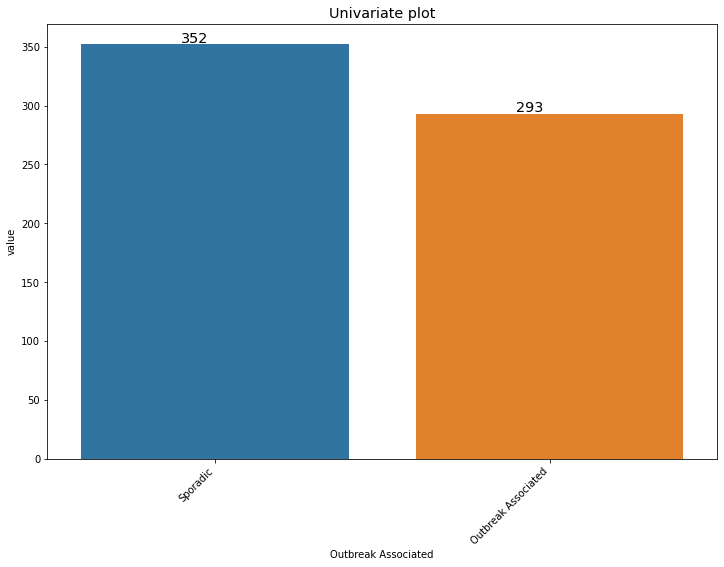

In [22]:
uni_categorical(df2[['Outbreak Associated']],'S')

We see that most data points falls into the category Sporadic.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Age Group ' 
                 Count  Percentage
20 to 29 Years     86       13.33
30 to 39 Years     82       12.71
40 to 49 Years     80       12.40
19 and younger     76       11.78
50 to 59 Years     73       11.32
60 to 69 Years     66       10.23
70 to 79 Years     66       10.23
80 to 89 Years     61        9.46
90 and older       55        8.53


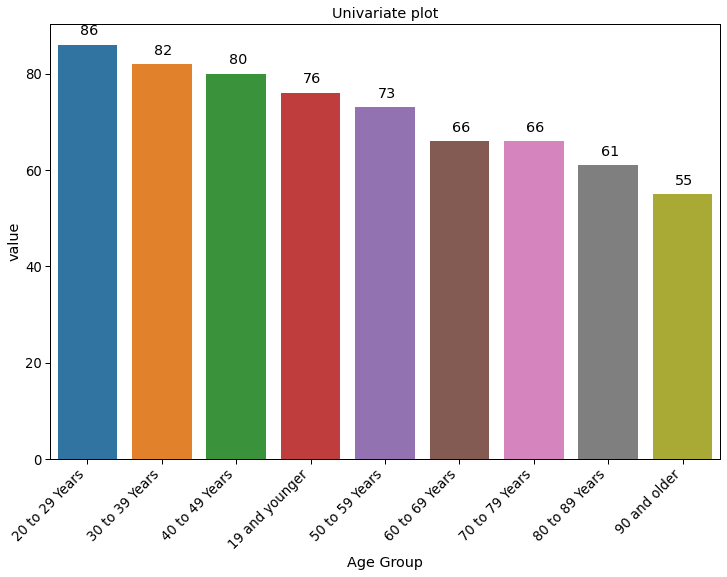

In [23]:
uni_categorical(df2[['Age Group']],'S')

Regarding Age Group, the most representative one is 20 to 29 Years.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Season ' 
         Count  Percentage
Spring    188       29.15
Winter    162       25.12
Autumn    153       23.72
Summer    142       22.02


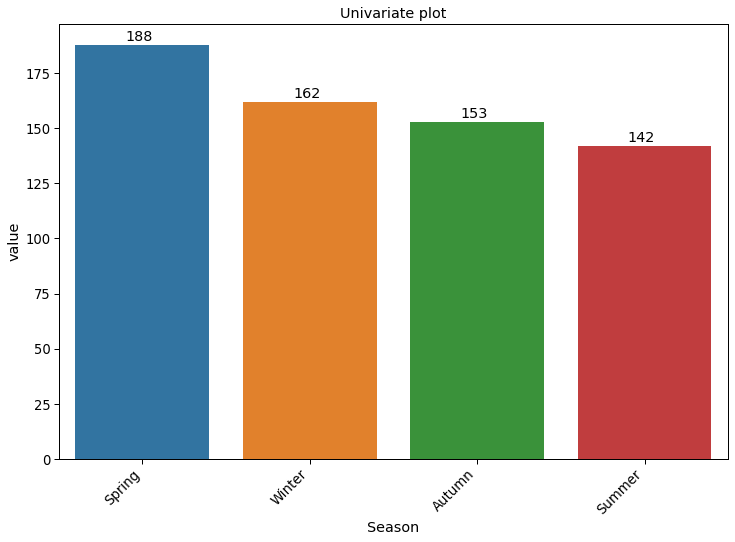

In [24]:
uni_categorical(df2[['Season']],'S')

We see that most of data points falls into Spring with a value of 188.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Episode Month ' 
     Count  Percentage
4      66       10.23
3      61        9.46
5      61        9.46
11     56        8.68
12     56        8.68
2      54        8.37
1      52        8.06
6      50        7.75
10     49        7.60
9      48        7.44
7      46        7.13
8      46        7.13


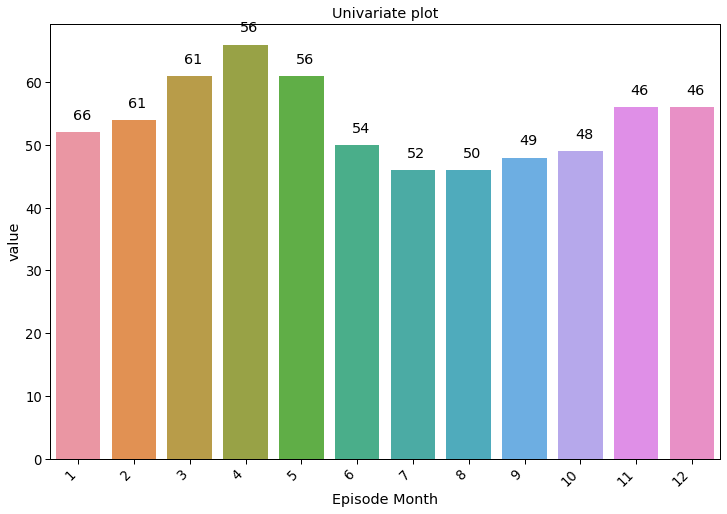

In [25]:
uni_categorical(df2[['Episode Month']],'S')

We see that regarding all observations, April is responsible for the most data points

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Client Gender ' 
                             Count  Percentage
FEMALE                        216       33.49
MALE                          214       33.18
UNKNOWN                       164       25.43
OTHER                          17        2.64
TRANSGENDER                    15        2.33
NON-BINARY                     10        1.55
NOT LISTED, PLEASE SPECIFY      4        0.62
TRANS MAN                       3        0.47
TRANS WOMAN                     2        0.31


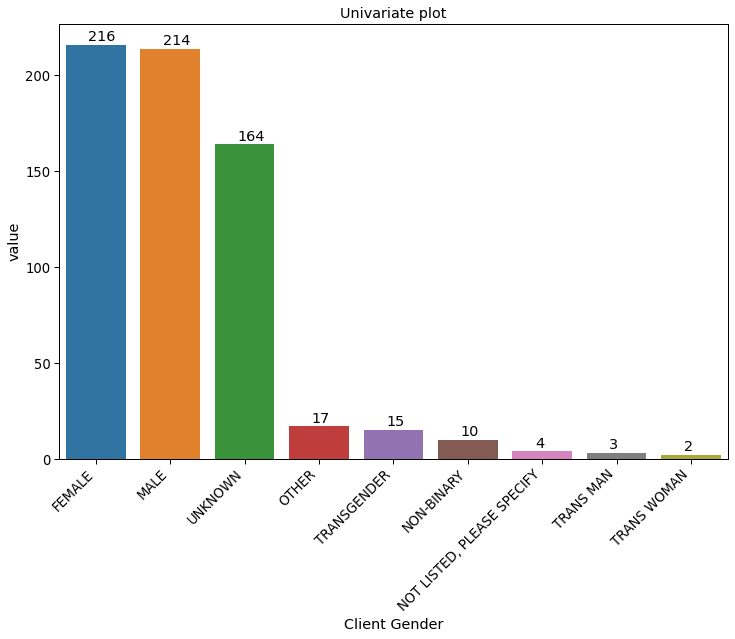

In [26]:
uni_categorical(df2[['Client Gender']],'S')

Females have a little more data points than males, with trans woman having the least.

############### Univariate analysis - Numerical ###############

This is univariate analysis for ' Count ' 
 count                     645.0
mean                 258.755039
std                  509.960063
min                         1.0
25%                         7.0
50%                        45.0
75%                       226.0
max                      3581.0
variance          260059.265988
IQR                       219.0
range                    3580.0
skewness               3.112715
kurtosis              11.091479
mode        0    1
dtype: int64
Name: Count, dtype: object


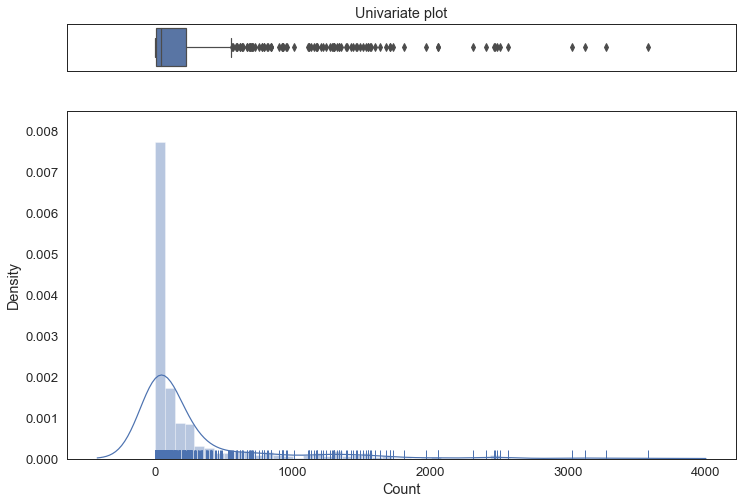

Kolmogorov's Statistics=0.858, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


In [27]:
uni_numerical(df2[['Count']])

We see a highly-right skewed distribution with the mode being 1.

Applying log:

############### Univariate analysis - Numerical ###############

This is univariate analysis for ' y transform ' 
 count                         645.0
mean                       3.671644
std                        2.270354
min                             0.0
25%                         1.94591
50%                        3.806662
75%                        5.420535
max                        8.183397
variance                   5.154508
IQR                        3.474625
range                      8.183397
skewness                  -0.095449
kurtosis                  -1.020936
mode        0    0.0
dtype: float64
Name: y transform, dtype: object


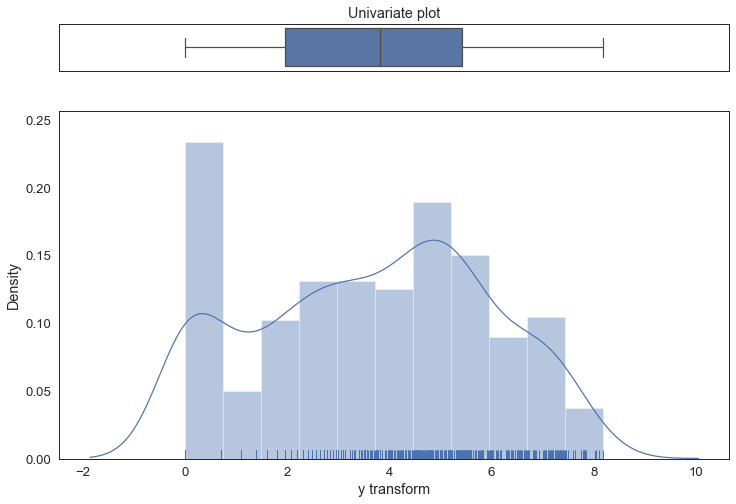

Kolmogorov's Statistics=0.735, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


In [28]:
df2['y transform']= np.log(df2['Count'])  
uni_numerical(df2[['y transform']])

df2.drop(['y transform'],axis=1,inplace=True)

We see that the skewness value dropped from 3.112 to -0.09 and the distribution approximate the bell shape, although it's still not normal. Applying the log to the feature in the dataset:

In [29]:
df2['Count'] = np.log(df2['Count'])

### Bivariate Analysis

#### Looking at target x categorical features:

We can see that there are difference between the groups distributions and this is confirmed by Kruskal's test.

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is Mann-Whitney U test for Count and Outbreak Associated

Mann-Whitney U test:
 Null hypothesis: The distribution of scores for the two groups are equal.
 Assumptions:
 1.Dependent variable that is measured at the continuous or ordinal level.
 2.Groups are independent of one another. 
 3.What's the shape of each group distribution.
	 a) Similar shapes: 
		 Alternative hypothesis: the medians of the two groups are not equal.
	 b) Different shapes:
		 Alternative hypothesis: the distribution of scores for the two groups are not equal.

Summary:
                       N   Mean     SD     SE  95% Conf.  Interval
Outbreak Associated                                               
Outbreak Associated  293  3.199  1.793  0.105      2.992     3.405
Sporadic             352  4.065  2.538  0.135      3.799     4.331


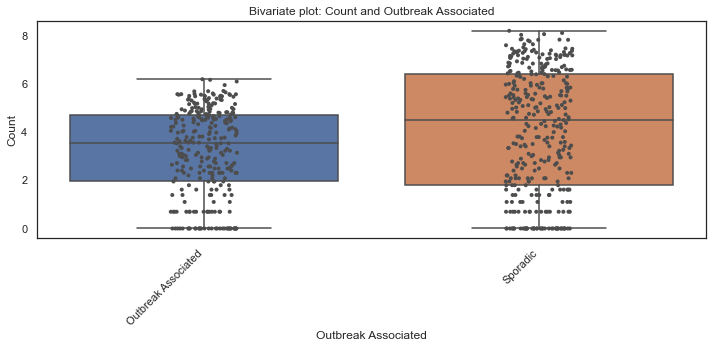


Levene's Statistics=59.014, p=0.000
Levene's test result: Unequal variances (reject H0)

Mann-Whitney U 's Statistics (unequal variances)=39726.000, p=0.000

Mann-Whitney U 's Null hypothesis: The distribution of scores for the two groups are equal.
Mann-Whitney U 's test result: The distribution of scores for the two groups are not equal. (reject H0)





In [30]:
target='Count'
bi_categorical_cont(df2[['Outbreak Associated',target]],target,'S')

We can see that there are difference between the groups distributions and this is confirmed by Kruskal's test.

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is ANOVA/Kruskal for Count and Age Group 

One-way ANOVA Assumptions
 In order to run a one-way ANOVA the following assumptions must be met:
 1.The response of interest is continuous and normally distributed for each treatment group.
 	CLT :
 		If looks normal each group must have more than 30 observations – no need for Normality’s test;
 		If moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;
	*If not normal, proceed to Kruskal test.
 2.Treatment groups are independent of one another. 
 3.There are no major outliers.
 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):
 	A .If variances are equal, then the assumptions o

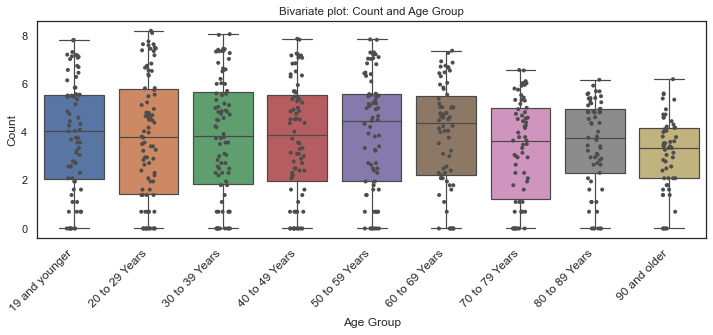


Levene's Statistics=4.236, p=0.000
Levene's test result: Unequal variances (reject H0)

Kruskal's Statistics(unequal variances)=9.629, p=0.292

Kruskal's Null hypothesis: All sample distributions are equal.
Kruskal's test result: All sample distributions are equal. (fail to reject H0)





In [31]:
bi_categorical_cont(df2[['Age Group',target]],target,'S')

We can see that there are difference between the groups distributions and this is confirmed by Kruskal's test.

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is ANOVA/Kruskal for Count and Season 

One-way ANOVA Assumptions
 In order to run a one-way ANOVA the following assumptions must be met:
 1.The response of interest is continuous and normally distributed for each treatment group.
 	CLT :
 		If looks normal each group must have more than 30 observations – no need for Normality’s test;
 		If moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;
	*If not normal, proceed to Kruskal test.
 2.Treatment groups are independent of one another. 
 3.There are no major outliers.
 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):
 	A .If variances are equal, then the assumptions of a

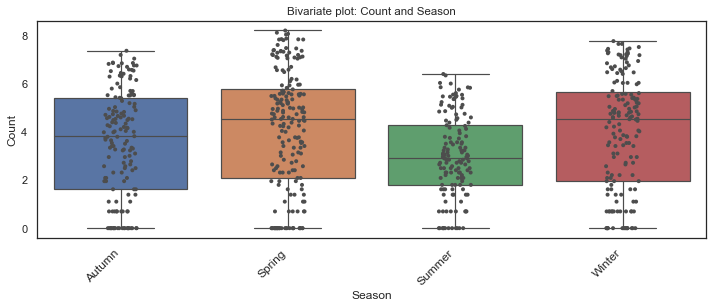


Levene's Statistics=9.080, p=0.000
Levene's test result: Unequal variances (reject H0)

Kruskal's Statistics(unequal variances)=24.830, p=0.000

Kruskal's Null hypothesis: All sample distributions are equal.
Kruskal's test result: One or more sample distributions are not equal. (reject H0)





In [32]:
bi_categorical_cont(df2[['Season',target]],target,'S')

We can see that there are difference between the groups distributions and this is confirmed by Kruskal's test.

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is ANOVA/Kruskal for Count and Episode Month 

One-way ANOVA Assumptions
 In order to run a one-way ANOVA the following assumptions must be met:
 1.The response of interest is continuous and normally distributed for each treatment group.
 	CLT :
 		If looks normal each group must have more than 30 observations – no need for Normality’s test;
 		If moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;
	*If not normal, proceed to Kruskal test.
 2.Treatment groups are independent of one another. 
 3.There are no major outliers.
 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):
 	A .If variances are equal, then the assumptio

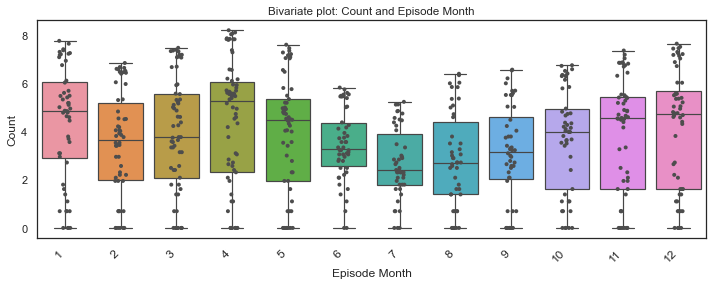


Levene's Statistics=2.945, p=0.001
Levene's test result: Unequal variances (reject H0)

Kruskal's Statistics(unequal variances)=37.619, p=0.000

Kruskal's Null hypothesis: All sample distributions are equal.
Kruskal's test result: One or more sample distributions are not equal. (reject H0)





In [33]:
bi_categorical_cont(df2[['Episode Month',target]],target,'S')

We can see that there are difference between the groups distributions and this is confirmed by Kruskal's test.

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is ANOVA/Kruskal for Count and Client Gender 

One-way ANOVA Assumptions
 In order to run a one-way ANOVA the following assumptions must be met:
 1.The response of interest is continuous and normally distributed for each treatment group.
 	CLT :
 		If looks normal each group must have more than 30 observations – no need for Normality’s test;
 		If moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;
	*If not normal, proceed to Kruskal test.
 2.Treatment groups are independent of one another. 
 3.There are no major outliers.
 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):
 	A .If variances are equal, then the assumptio

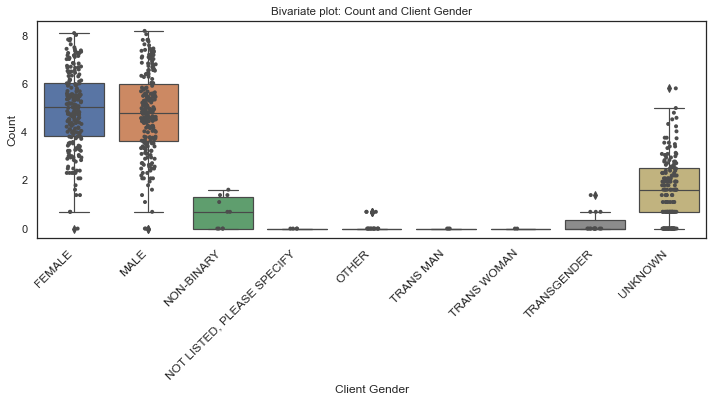


Levene's Statistics=8.915, p=0.000
Levene's test result: Unequal variances (reject H0)

Kruskal's Statistics(unequal variances)=355.682, p=0.000

Kruskal's Null hypothesis: All sample distributions are equal.
Kruskal's test result: One or more sample distributions are not equal. (reject H0)





In [34]:
bi_categorical_cont(df2[['Client Gender',target]],target,'S')

We can see that there are difference between the groups distributions and this is confirmed by Kruskal's test.

# Defining Model

### Encoding categorical variables:

In [35]:
# Creating copy of df1:
df_dummy = df2.copy()

#Dummy variable encoding for all other categorical features: 
cols = list(df_dummy.columns[df_dummy.dtypes=='category'])
df_dummy = pd.get_dummies(df_dummy,columns=cols,drop_first=True).reset_index(drop = True)

Separating predictors and target:

In [36]:
X = df_dummy.drop([target],axis=1)
y = df_dummy[target]

Looking at the first observations of predictors and target: 

In [37]:
print(X.head(3))

   Outbreak Associated_Sporadic  Age Group_20 to 29 Years  \
0                             0                         0   
1                             0                         0   
2                             0                         0   

   Age Group_30 to 39 Years  Age Group_40 to 49 Years  \
0                         0                         0   
1                         0                         0   
2                         0                         0   

   Age Group_50 to 59 Years  Age Group_60 to 69 Years  \
0                         0                         0   
1                         0                         0   
2                         0                         0   

   Age Group_70 to 79 Years  Age Group_80 to 89 Years  Age Group_90 and older  \
0                         0                         0                       0   
1                         0                         0                       0   
2                         0                         0 

In [38]:
print(y.head(3))

0    3.218876
1    3.332205
2    0.000000
Name: Count, dtype: float64


### Verifying collinearity

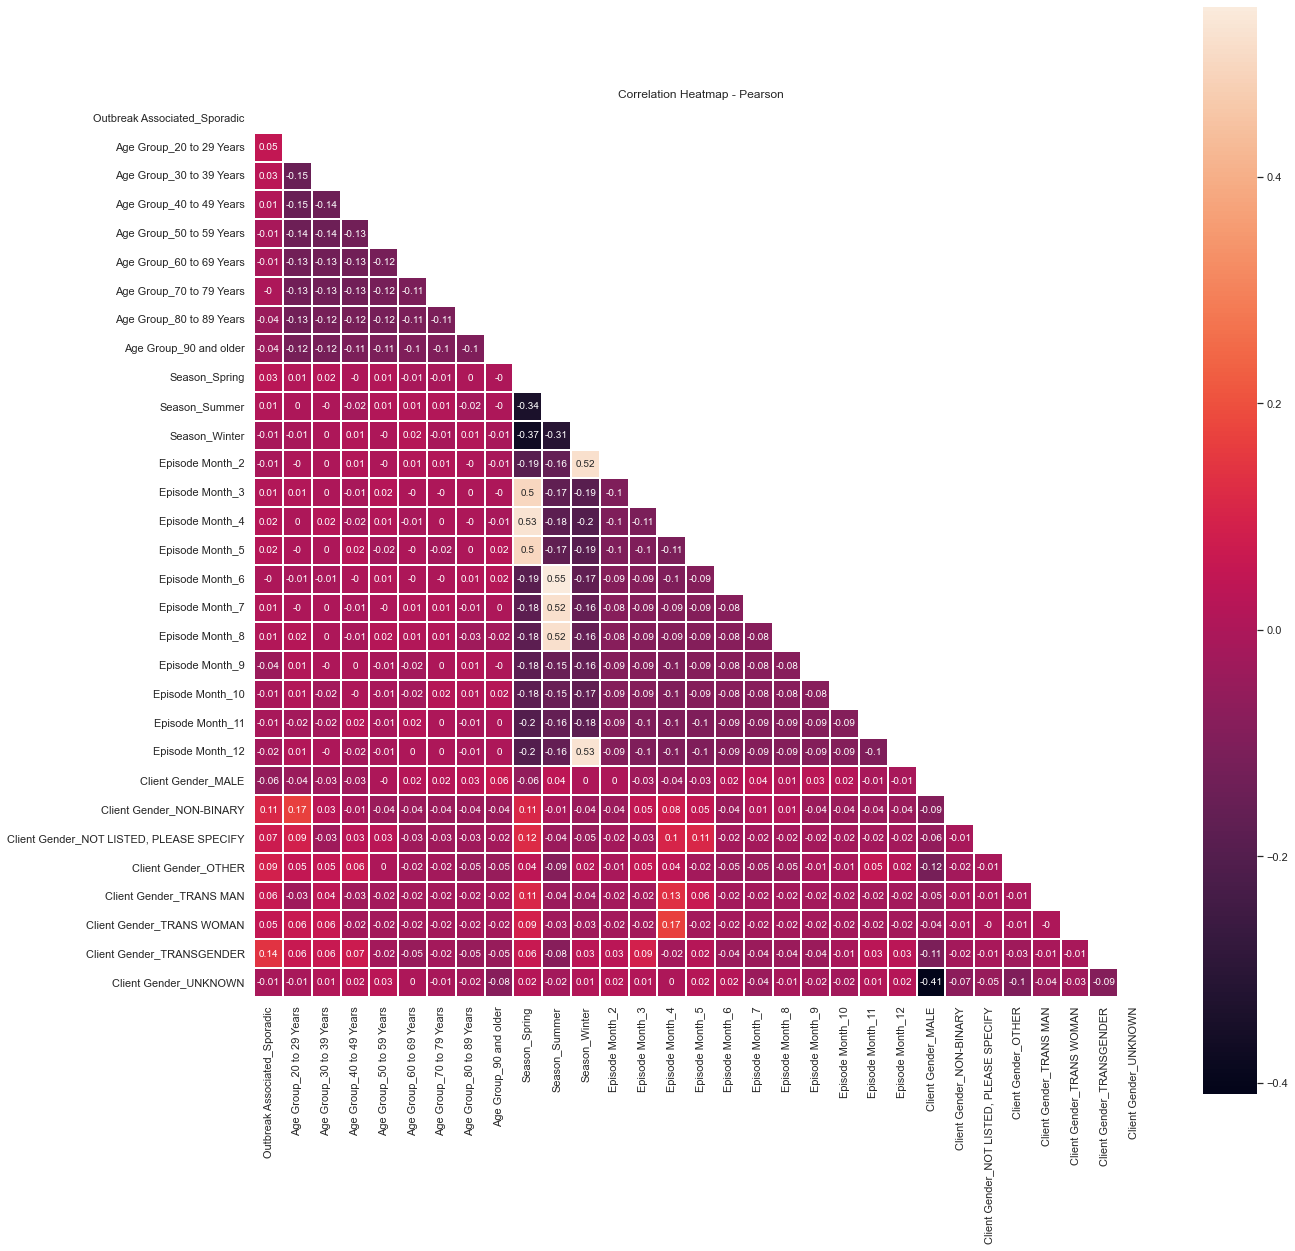

In [39]:
sns.set_palette("dark") # colorblind   pastel
sns.set(style="white",font_scale=1) #whitegrid ticks
    
mask = np.zeros_like(X.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(round(X.corr(method='pearson'),2),annot=True, annot_kws={"fontsize":10},square=True, linewidths=0.01,mask=mask,ax=ax)
plt.title('Correlation Heatmap - Pearson')   
plt.show()

Due to the number of features, the scatter plot doesn't help in the verification of collinearity. So, I'll draw the correlation table:

In [40]:
round(X.corr(),2)


,Outbreak Associated_Sporadic,Age Group_20 to 29 Years,Age Group_30 to 39 Years,Age Group_40 to 49 Years,Age Group_50 to 59 Years,Age Group_60 to 69 Years,Age Group_70 to 79 Years,Age Group_80 to 89 Years,Age Group_90 and older,Season_Spring,...,Episode Month_11,Episode Month_12,Client Gender_MALE,Client Gender_NON-BINARY,"Client Gender_NOT LISTED, PLEASE SPECIFY",Client Gender_OTHER,Client Gender_TRANS MAN,Client Gender_TRANS WOMAN,Client Gender_TRANSGENDER,Client Gender_UNKNOWN
Outbreak Associated_Sporadic,1.00,0.05,0.03,0.01,-0.01,-0.01,-0.00,-0.04,-0.04,0.03,...,-0.01,-0.02,-0.06,0.11,0.07,0.09,0.06,0.05,0.14,-0.01
Age Group_20 to 29 Years,0.05,1.00,-0.15,-0.15,-0.14,-0.13,-0.13,-0.13,-0.12,0.01,...,-0.02,0.01,-0.04,0.17,0.09,0.05,-0.03,0.06,0.06,-0.01
Age Group_30 to 39 Years,0.03,-0.15,1.00,-0.14,-0.14,-0.13,-0.13,-0.12,-0.12,0.02,...,-0.02,-0.00,-0.03,0.03,-0.03,0.05,0.04,0.06,0.06,0.01
Age Group_40 to 49 Years,0.01,-0.15,-0.14,1.00,-0.13,-0.13,-0.13,-0.12,-0.11,-0.00,...,0.02,-0.02,-0.03,-0.01,0.03,0.06,-0.03,-0.02,0.07,0.02
Age Group_50 to 59 Years,-0.01,-0.14,-0.14,-0.13,1.00,-0.12,-0.12,-0.12,-0.11,0.01,...,-0.01,-0.01,-0.00,-0.04,0.03,0.00,-0.02,-0.02,-0.02,0.03
Age Group_60 to 69 Years,-0.01,-0.13,-0.13,-0.13,-0.12,1.00,-0.11,-0.11,-0.10,-0.01,...,0.02,0.00,0.02,-0.04,-0.03,-0.02,-0.02,-0.02,-0.05,0.00
Age Group_70 to 79 Years,-0.00,-0.13,-0.13,-0.13,-0.12,-0.11,1.00,-0.11,-0.10,-0.01,...,0.00,0.00,0.02,-0.04,-0.03,-0.02,-0.02,-0.02,-0.02,-0.01
Age Group_80 to 89 Years,-0.04,-0.13,-0.12,-0.12,-0.12,-0.11,-0.11,1.00,-0.10,0.00,...,-0.01,-0.01,0.03,-0.04,-0.03,-0.05,-0.02,-0.02,-0.05,-0.02
Age Group_90 and older,-0.04,-0.12,-0.12,-0.11,-0.11,-0.10,-0.10,-0.10,1.00,-0.00,...,0.00,0.00,0.06,-0.04,-0.02,-0.05,-0.02,-0.02,-0.05,-0.08
Season_Spring,0.03,0.01,0.02,-0.00,0.01,-0.01,-0.01,0.00,-0.00,1.00,...,-0.20,-0.20,-0.06,0.11,0.12,0.04,0.11,0.09,0.06,0.02


We see that most of the features are not correlated, the highest correlation value is 0.55 between Episode Month_6 and Season_Summer.

#### Applying the OLS

Using Ordinary Least Squares:

In [41]:
X1 = sm.add_constant(X)
X1.head()
ols = sm.OLS(y,X1.astype(float)) 
lr = ols.fit()

print(lr.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     164.1
Date:                Fri, 10 Sep 2021   Prob (F-statistic):          2.42e-264
Time:                        15:34:16   Log-Likelihood:                -755.02
No. Observations:                 645   AIC:                             1568.
Df Residuals:                     616   BIC:                             1698.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Applying Backward Feature elimination, since we can see that there are some features with a high p-value: as Age Group_30 to 39 Years, for example.

In [42]:
#Backward Feature Elimination 
maxp = lr.pvalues.max()
while(maxp > 0.025):
    X1.drop(lr.pvalues.idxmax(),axis=1,inplace=True) 
    ols = sm.OLS(y,X1.astype(float))
    lr = ols.fit()
    maxp = lr.pvalues.max()
print(lr.summary())    

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     216.2
Date:                Fri, 10 Sep 2021   Prob (F-statistic):          1.15e-269
Time:                        15:34:16   Log-Likelihood:                -761.51
No. Observations:                 645   AIC:                             1567.
Df Residuals:                     623   BIC:                             1665.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### SkLearn will be used to do the Linear Regression

#### Dividing training and test data sets:
     - 70% for training dataset and 30% for testing.

In [43]:
# X =  X1.drop('const',axis=1)

X_train, X_test,y_train,y_test = train_test_split(X,y,random_state=6,test_size=0.3)

#print(X_train.head(2))
#print(y_train.head(2))

### Testing the model:

In [44]:
lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)

LinearRegression()

#### Training score: 

In [45]:
R2 = lrmodel.score(X_train,y_train)
print('Training R2 =',R2) #r2 value
print('Training Adj-R2 =',adjR2(X_train,R2))

print('Training R2 - Training Adj-R2: ',R2-adjR2(X_train,R2))

#predict y values
y_pred = lrmodel.predict(X_train)
y_pred

# mse = mean[(y_pred - y_test)^2])
print('RMSE value: ',mean_squared_error(y_train,y_pred, squared=False)) 
# mse = mean[(y_pred - y_test)^2]) Docs: squaredbool, default=True 
#If True returns MSE value, if False returns RMSE value.


Training R2 = 0.8836483399582606
Training Adj-R2 = 0.8750399832487286
Training R2 - Training Adj-R2:  0.008608356709532083
RMSE value:  0.7577684554856046


For the training we see:

    - An R-Squared value of approximatelly 0.88, meaning that the independent variable (X) would explain  approximatelly 88% of the variation of the y(Count of Cases). 
    - An Adjusted R-Squared value of approximatelly 0.88, meaning that the meaningful independent variables (Xs,e.g: Outbreak Associated of the Sporadic category, Epidode Month February,etc. ) explaing ~88% of the variation of the y(Count of Cases);
    - A RMSE value of approximately 0.76, which means that the average of the errors are around less than 68% of the expected value.

#### Test score: 

In [46]:
R2 = lrmodel.score(X_test,y_test)
print('Test R2 =',R2) #r2 value
print('Test Adj-R2 =',adjR2(X_test,R2))

#predict y values
y_pred = lrmodel.predict(X_test)
y_pred

# mse = mean[(y_pred - y_test)^2])
print('RMSE value: ',mean_squared_error(y_test,y_pred, squared=False)) 
# mse = mean[(y_pred - y_test)^2]) Docs: squaredbool, default=True 
#If True returns MSE value, if False returns RMSE value.


Test R2 = 0.8701121896301919
Test Adj-R2 = 0.8452571148063397
RMSE value:  0.8550471737644835


For the testing we see:

    - An R-Squared value of approximatelly 0.88, meaning that the independent variable (X) would explain  apporximatelly 88% of the variation of the y(Count of Cases); 
    - An Adjusted R-Squared value of approximatelly 0.85, meaning that the independent variables (Xs,e.g: Outbreak Associated of the Sporadic category, Epidode Month March, Gender Male,etc. ) explaing  approximately 85% of the variation of the y(Count of Cases);
    - A RMSE value of approximately 0.85, which means that the average of the errors are around less than 68% of the expected value.

#### k-fold cross validation using linear regression model:

In [47]:
cross = cross_val_score(LinearRegression(),X,y)
print('Mean Cross validation score is:',cross.mean())
print('Minimum Cross validation score is:', cross.min())
print('Maximum Cross validation score is:', cross.max())

Mean Cross validation score is: 0.5974384121669322
Minimum Cross validation score is: 0.2699496268511409
Maximum Cross validation score is: 0.8653500816899238


Fitting the model with Linear Regression:

In [48]:
model = LinearRegression()
model.fit(X,y)

#Creating dictionary with coefficients and features to consult later
coef_dict = {}
coef_plot = {}
for coef, feat in zip(model.coef_,X):
    coef_dict[feat] = '(' + str(coef) + ')'
    coef_plot[feat] = coef

In [49]:
#### Intercept:

In [50]:
print('Intercept: ',model.intercept_)

Intercept:  -3019807574453.0933


## Coefficient Plot:

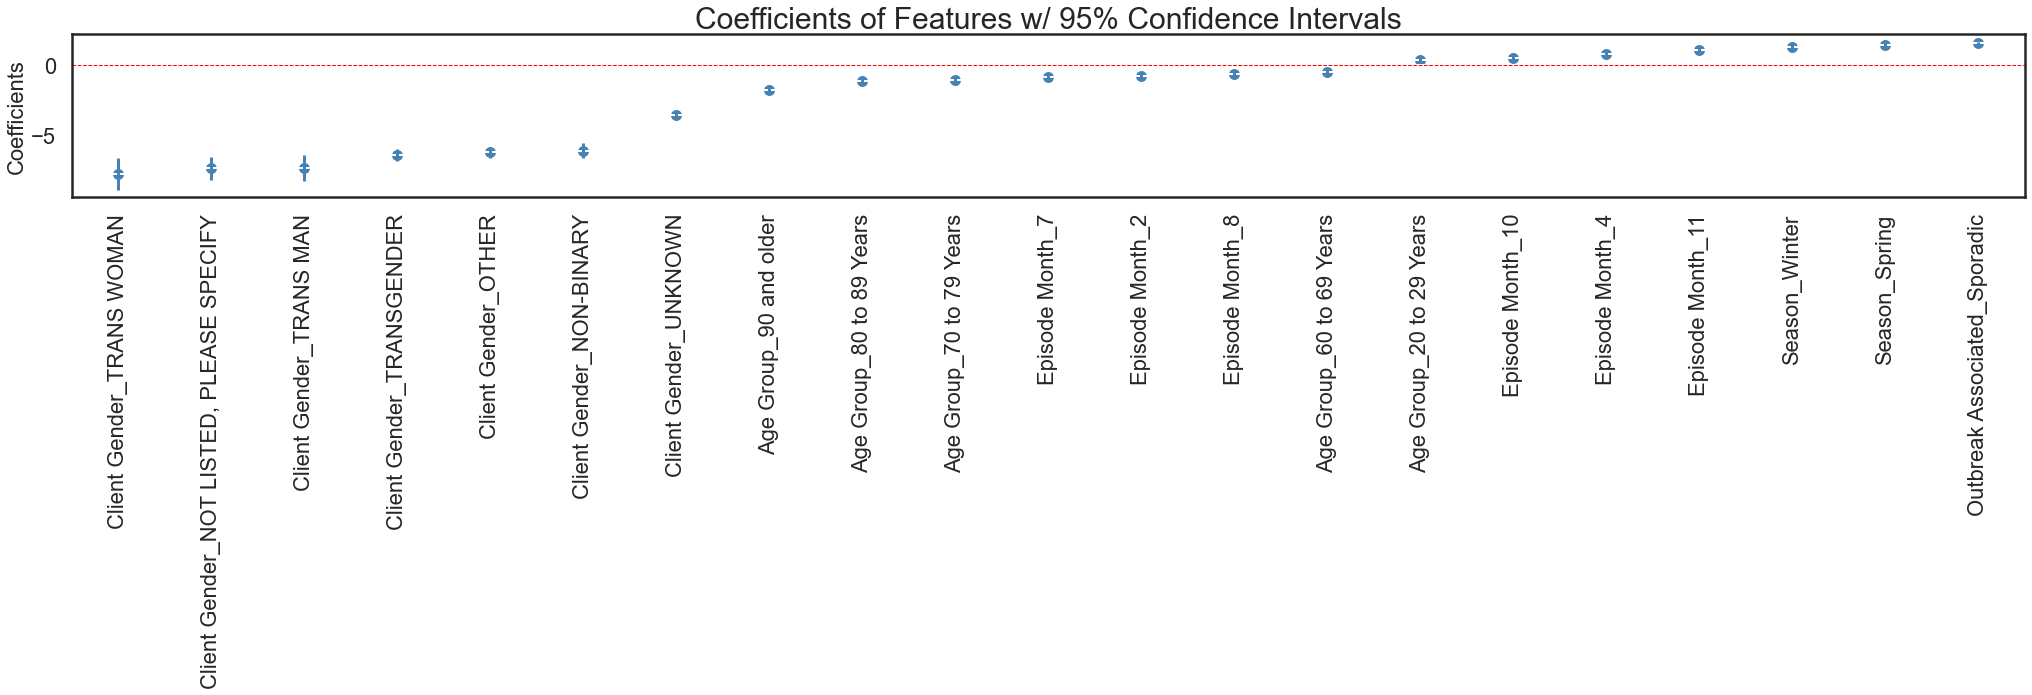

In [51]:
coefplot(lr)

Model equation: 

In [52]:
eq = ' + '.join('*'.join((val,key)) for (key,val) in coef_dict.items())
print(model.intercept_,' + ',eq)

-3019807574453.0933  +  (1.5441079663223745)*Outbreak Associated_Sporadic + (0.35638162207921087)*Age Group_20 to 29 Years + (0.1483642524550446)*Age Group_30 to 39 Years + (0.019967929529485447)*Age Group_40 to 49 Years + (-0.12071009668849385)*Age Group_50 to 59 Years + (-0.5075667886416892)*Age Group_60 to 69 Years + (-1.0606926328873354)*Age Group_70 to 79 Years + (-1.1114359496043367)*Age Group_80 to 89 Years + (-1.750224393004825)*Age Group_90 and older + (2943219376811.681)*Season_Spring + (2763434204188.5405)*Season_Summer + (3019807574458.3223)*Season_Winter + (-0.7900069436320135)*Episode Month_2 + (76588197646.71722)*Episode Month_3 + (76588197647.52966)*Episode Month_4 + (76588197646.74487)*Episode Month_5 + (256373370268.61624)*Episode Month_6 + (256373370267.62393)*Episode Month_7 + (256373370267.8137)*Episode Month_8 + (3019807574456.811)*Episode Month_9 + (3019807574457.4883)*Episode Month_10 + (3019807574458.0522)*Episode Month_11 + (-0.02222203034754386)*Episode Month

# Conclusions/Inferences

This model may explain societal factors but exercising caution is recommended, since k-fold R-Square value is very low(less than 60%).


This model points, for example:
- Being a female have more risk of having a positive case of COVID by a variation of +7.91 compared to a trans-woman, suggesting that more attention may be given to females to diminish their exposition. 
- We also see that outbreak contamination presents a higher risk than sporadic ones explaining the variation of positive cases by approximately +1.5, indicating that it’s past due to give proper care to such sites.
- Winter and Spring have also an impact in rising the risk of positive cases.


As k-fold R-Square value is very low a different model (non-linear) may be better to predict the output feature.